#***Introduction***
___
##**Background Context** (with references)

In this sci-fi scenario, the Spaceship Titanic, a massive passenger spacecraft, collides with a mysterious spacetime anomaly causing nearly half of its passengers to vanish. (Kaggle, 2022) Unlike the original Titanic sinking, these passengers weren’t killed but were transported to an unknown alternate dimension. Our goal is to predict which passengers disappeared (labeled **Transported = True**) using their onboard records such as cabin location, spending history, and cryo-sleep status. This mirrors real-world disaster response systems, where predicting who needs rescue most urgently can save lives.
___
##**Hypothesis/Problem Statement**

We aim to predict with binary classification whether a passenger was transported using features like cryo-sleep status, cabin location, and spending patterns.
___
##**Importance** (the why?)

Imagine if the Titanic’s crew had a tool to predict who would be at risk. This is similar to what we're building and the reason why it is important is because:

1. Rescue Priority: If we can predict who vanished, search teams can focus efforts on high-risk groups.

2. Preventive Design: Future spacecraft could reinforce vulnerable areas.

3. Economic Impact: Reducing false negatives (missed rescues) saves lives, while minimizing false positives avoids wasted resources. This problem mirrors real-world disaster response such as the Titanic lifeboat prioritization.
___
##**Data Relevance**

The dataset’s features directly address our hypotheses because it serves as a passenger manifest with clues that might explain who vanished.

1. CryoSleep (Boolean): Passengers in cryo-sleep were physically inert.

2. Cabin Deck (A–G, from split ‘Cabin’ feature): Deck location implies proximity to potential anomaly epicenters.

3. Age (Numeric): Children might be prioritized for evacuation.
___
##**Novelty & Significance**

We avoid obvious questions like "Do VIPs survive more?" to explore:

1. The Family Effect: Did families vanish together? (Using hidden PassengerId groupings.)

2. Anomaly Hotspots: Did certain cabin sections have higher vanish rates?

2. Money vs. Survival: Counterintuitively, maybe big spenders were more vulnerable?

#***Importing Libraries and Data***

In [5]:
# Installations (run only once)
!pip install eli5 catboost

# Standard Libraries
import numpy as np
import pandas as pd
import time
import itertools
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import plotly.express as px
from google.colab import files

# Data Processing & Feature Engineering
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                 OneHotEncoder, LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

# Model Selection & Evaluation
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                   RandomizedSearchCV, StratifiedKFold,
                                   cross_val_score)
from sklearn.metrics import (accuracy_score, roc_curve, auc,
                            confusion_matrix, classification_report,
                            recall_score, precision_score, f1_score,
                            roc_auc_score, ConfusionMatrixDisplay,
                            RocCurveDisplay, precision_recall_curve)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
import eli5
from eli5.sklearn import PermutationImportance

# Machine Learning Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [6]:
# The .csv files of the dataset can be found under the data tab of the Kaggle competition link.
# https://www.kaggle.com/competitions/spaceship-titanic/data
# Run this snippet of code and upload both train.csv and test.csv

uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [7]:
# Loading the data
train = pd.read_csv('../content/train.csv')
test = pd.read_csv('../content/test.csv')

#***Dataset Description & Analysis***

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

* Destination - The planet the passenger will be debarking to.

* Age - The age of the passenger.

* VIP - Whether the passenger has paid for special VIP service during the voyage.

* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

* Name - The first and last names of the passenger.

* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.



In [8]:
# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Train set shape: (8693, 14)
Test set shape: (4277, 13)


In [9]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [10]:
# Missing values analysis
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

TEST SET MISSING VALUES:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [11]:
# Duplicates values analysis
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


In [12]:
# Cardinality of the features
train.nunique()

,0
PassengerId,8693
HomePlanet,3
CryoSleep,2
Cabin,6560
Destination,3
Age,80
VIP,2
RoomService,1273
FoodCourt,1507
ShoppingMall,1115


In [13]:
# Data types of the features
train.dtypes

,0
PassengerId,object
HomePlanet,object
CryoSleep,object
Cabin,object
Destination,object
Age,float64
VIP,object
RoomService,float64
FoodCourt,float64
ShoppingMall,float64


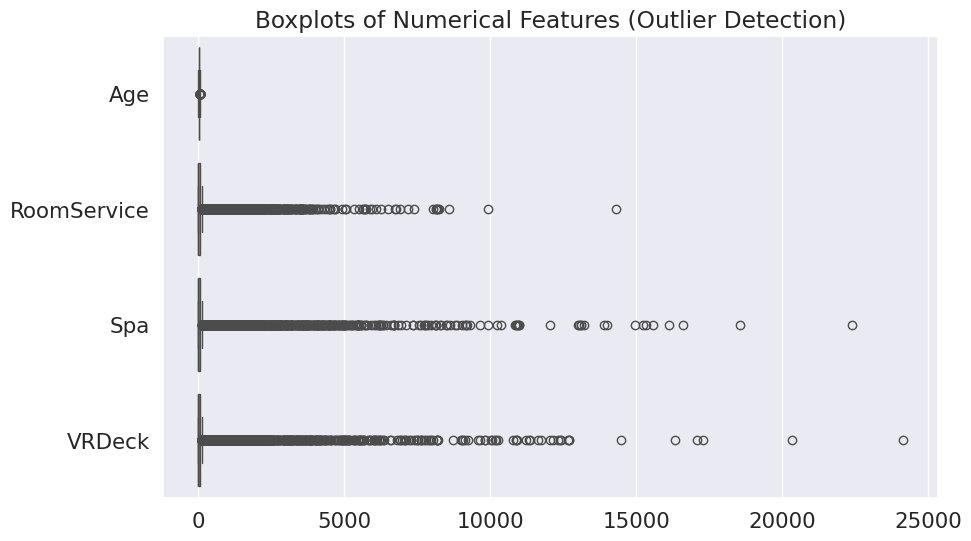

In [14]:
# Outlier detection for numerical features
num_features = ['Age', 'RoomService', 'Spa', 'VRDeck']
plt.figure(figsize=(10, 6))
sns.boxplot(data=train[num_features], orient='h')
plt.title("Boxplots of Numerical Features (Outlier Detection)")
plt.show()

In [15]:
# Calculate Z-scores for numerical features
z_scores = np.abs(stats.zscore(train[num_features].select_dtypes(include='number')))
outliers = (z_scores > 3).sum()  # Threshold = 3 standard deviations
print("Number of outliers per feature (Z-score > 3):\n", outliers)

Number of outliers per feature (Z-score > 3):
 0


In [16]:
# Check plausible ranges for each feature
for col in num_features:
    print(f"{col}: min={train[col].min()}, max={train[col].max()}")

Age: min=0.0, max=79.0
RoomService: min=0.0, max=14327.0
Spa: min=0.0, max=22408.0
VRDeck: min=0.0, max=24133.0


In [17]:
# Detect negative values in numerical features
negative_values = train[num_features].lt(0).sum()
print("Negative values per feature:\n", negative_values)

Negative values per feature:
 Age            0
RoomService    0
Spa            0
VRDeck         0
dtype: int64


#***Exploring the Dataset***

###**Target Distribution by Transport Status**

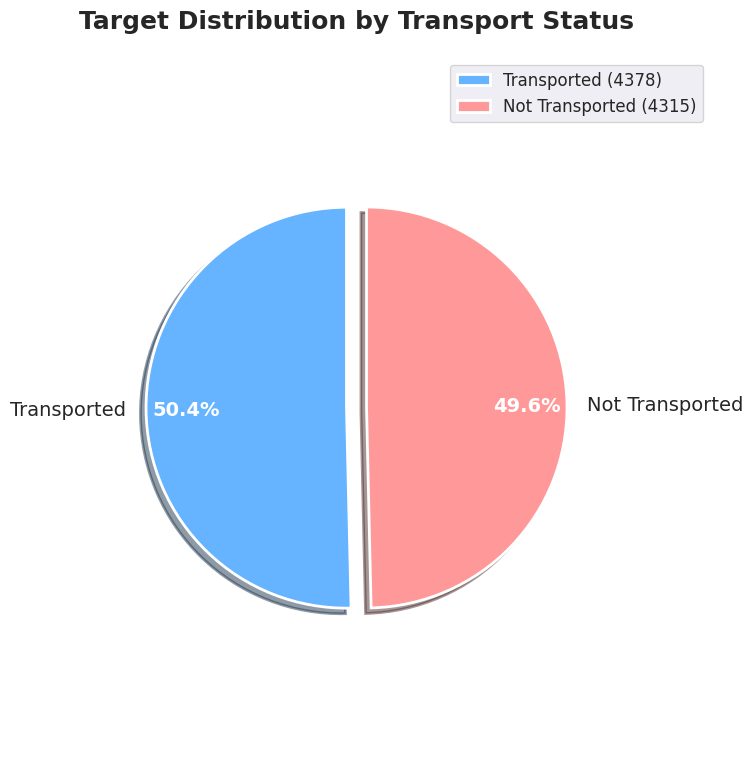

In [18]:
# Pie Chart of target distribution by transport status
plt.figure(figsize=(8, 8))

colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0.05)
title_font = {'fontsize': 18, 'fontweight': 'bold', 'pad': 20}

patches, texts, autotexts = plt.pie(
    train['Transported'].value_counts(),
    labels=['Transported', 'Not Transported'],
    colors=colors,
    explode=explode,
    autopct='%1.1f%%',
    pctdistance=0.8,
    shadow=True,
    startangle=90,
    textprops={'fontsize': 14},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

plt.title("Target Distribution by Transport Status", **title_font)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(14)

legend_labels = [f'{label} ({value})' for label, value in zip(
    ['Transported', 'Not Transported'],
    train['Transported'].value_counts()
)]
plt.legend(
    patches, legend_labels,
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    fontsize=12
)

plt.axis('equal')
plt.tight_layout()
plt.show()

#### Insights:
The dataset is highly balanced, so theres no need to perform any under/over-sampling.

### **Histogram of Age Distribution by Transport Status**

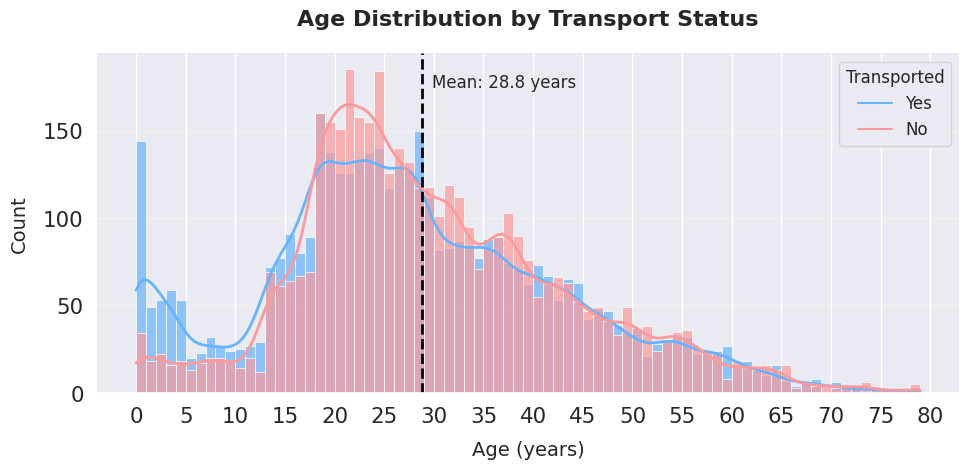

In [19]:
# Histogram of age distribution by transport status
plt.figure(figsize=(10, 5))

ax = sns.histplot(
    data=train,
    x='Age',
    hue='Transported',
    binwidth=1,
    kde=True,
    palette=['#ff9999', '#66b3ff'],
    alpha=0.7,
    edgecolor='white',
    linewidth=0.5,
    kde_kws={'bw_adjust': 0.5}
)

plt.title('Age Distribution by Transport Status',
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Age (years)', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)

plt.legend(
    title='Transported',
    labels=['Yes', 'No'],
    fontsize=12,
    title_fontsize=12
)

ax.grid(axis='y', alpha=0.3)
sns.despine(left=True)

mean_age = train['Age'].mean()
plt.axvline(mean_age, color='black', linestyle='--', linewidth=1)
plt.text(mean_age+1, ax.get_ylim()[1]*0.9,
         f'Mean: {mean_age:.1f} years',
         fontsize=12)

plt.xticks(np.arange(0, train['Age'].max()+5, 5))

for line in ax.lines:
    line.set_linewidth(2)

plt.tight_layout()
plt.show()

#### Insights:
* 0 - 18 year olds were **more** likely to be transported than not.
* 18 - 25 year olds were **less** likely to be transported that not.
* Ages 25 and older were about **equally** likely to be transported than not.

### **Histograms of Expenditure Features by Transport Status**

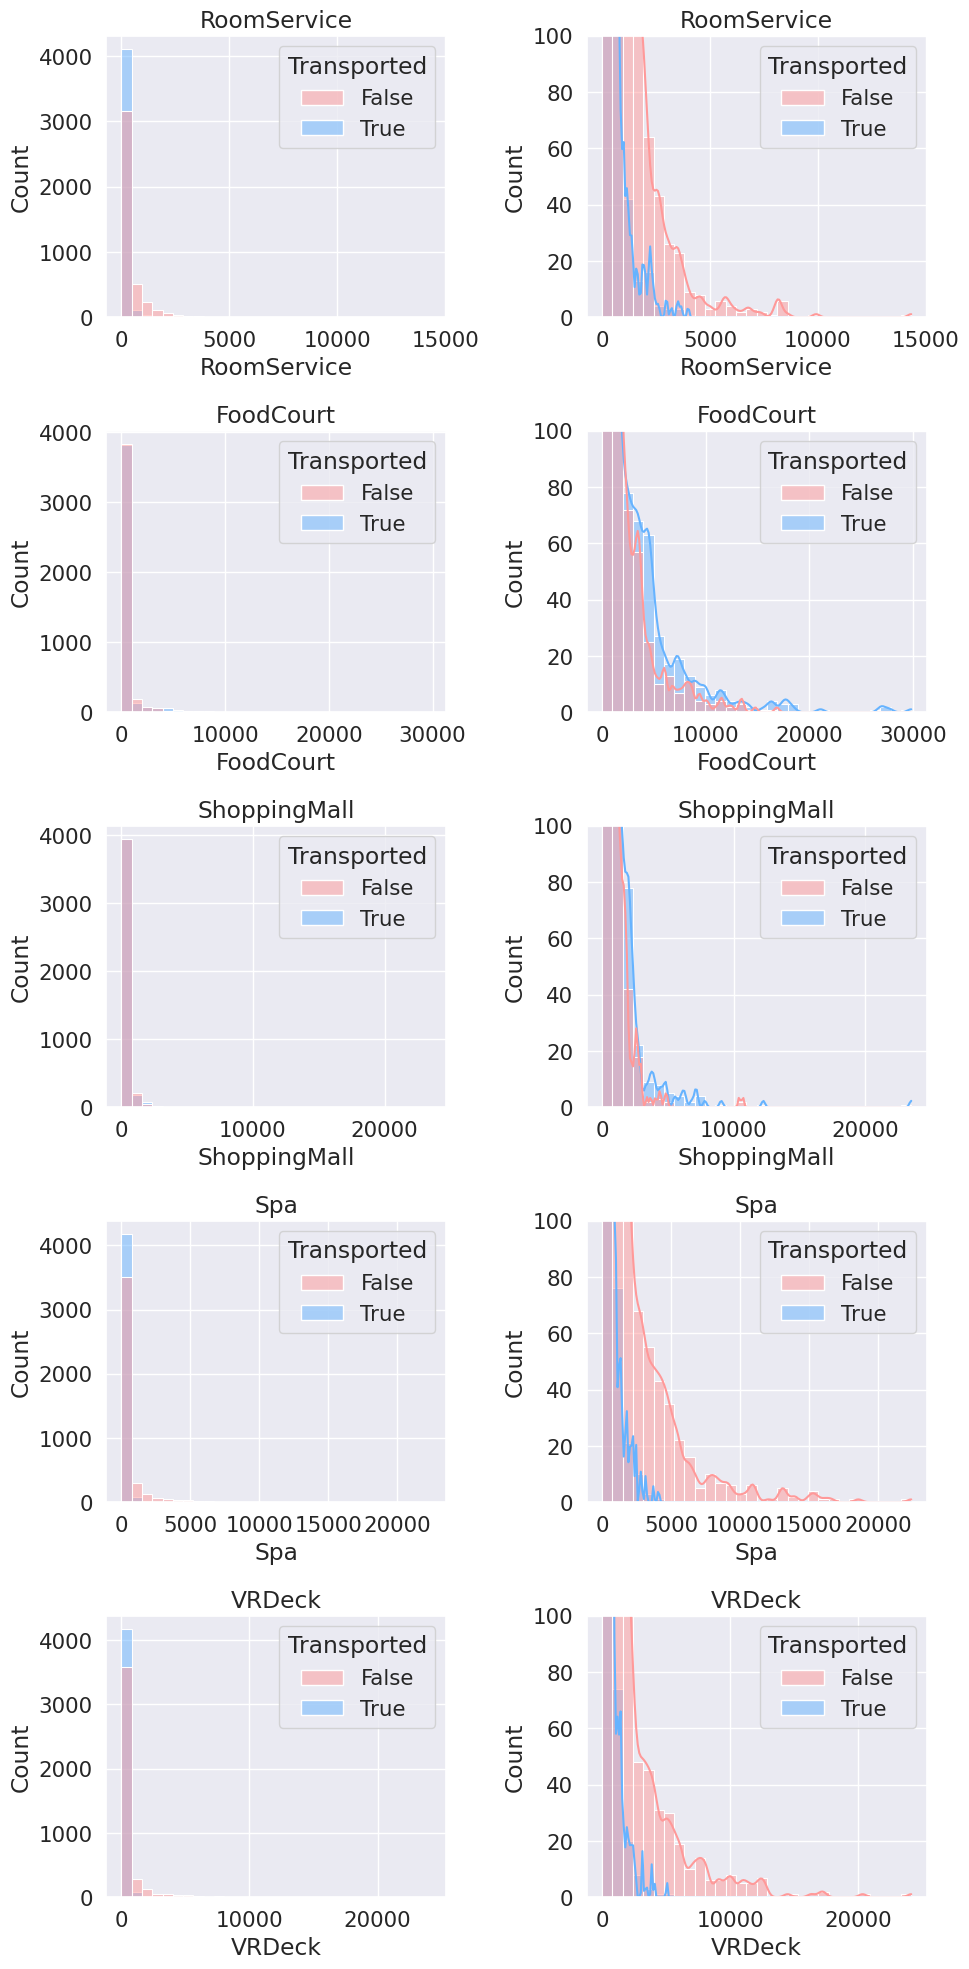

In [20]:
# Expenditure features
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

palette = {True: '#66b3ff', False: '#ff9999'}

fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(exp_feats):

    ax = fig.add_subplot(5, 2, 2*i+1)
    sns.histplot(
        data=train,
        x=var_name,
        bins=30,
        kde=False,
        hue='Transported',
        palette=palette,
        ax=ax
    )
    ax.set_title(var_name)

    ax = fig.add_subplot(5, 2, 2*i+2)
    sns.histplot(
        data=train,
        x=var_name,
        bins=30,
        kde=True,
        hue='Transported',
        palette=palette,
        ax=ax
    )
    plt.ylim([0, 100])
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

#### Insights:
* Most people don't spend any money.
* The distribution of spending decays exponentially.
* There are a small number of outliers.
* people who were transported tended to spend less.



### **Categorical Features by Transport Status**

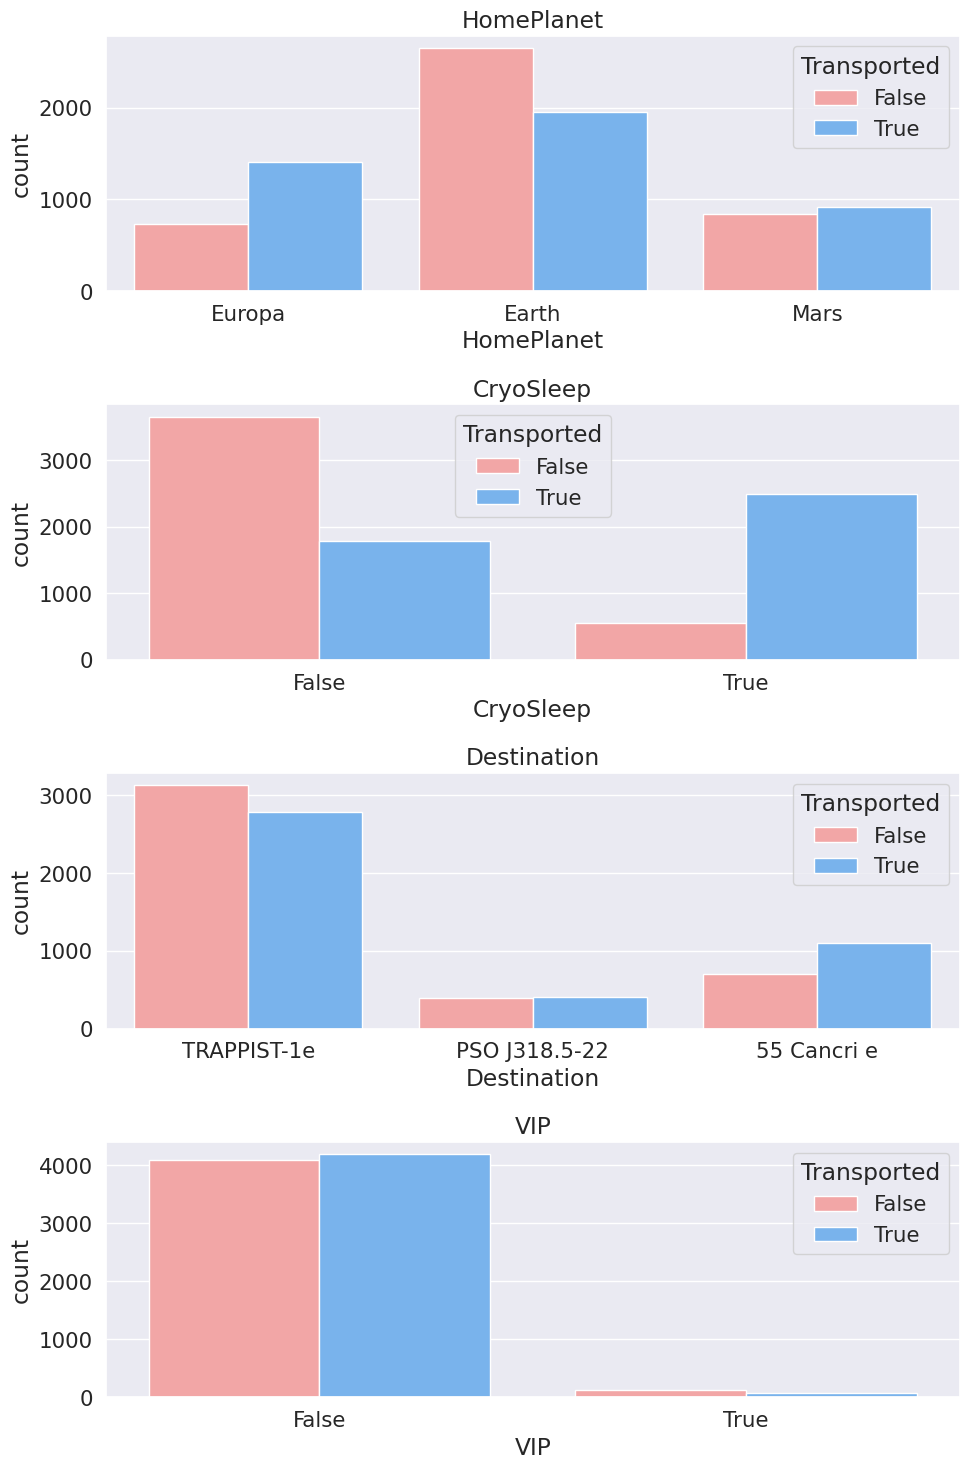

In [21]:
# Categorical features
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

palette = {True: '#66b3ff', False: '#ff9999'}

fig = plt.figure(figsize=(10, 15))
for i, var_name in enumerate(cat_feats):
    ax = fig.add_subplot(4, 1, i+1)
    sns.countplot(
        data=train,
        x=var_name,
        hue='Transported',
        palette=palette,
        ax=ax
    )
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

#### Insights:
* VIP does not appear to be a useful feature because the target split is more or less equal.
* Cryosleep appears to be the most useful feature in contrast.

### **Qualitative Features**

In [22]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


#### Insights:
* PassengerID takes the form gggg_pp where gggg indicates the group a passenger is travelling with and pp is their number within said group.
* Cabin takes the form of deck/number/side where side can be either P for Port or S for Starboard.

# ***Feature Engineering***
A common saying in machine learning is "garbage in, garbage out" which means that if a machine learning model is trained on poor quality or flawed data, it will produce inaccurate or unreliable results. This is the same reason why we want to employ feature engineering to create better models.

### **Age Status**
Divide age feature into groups as it will be helpful for filling missing values like expenditure according to age.

In [23]:
# New features - Training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - Testing set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

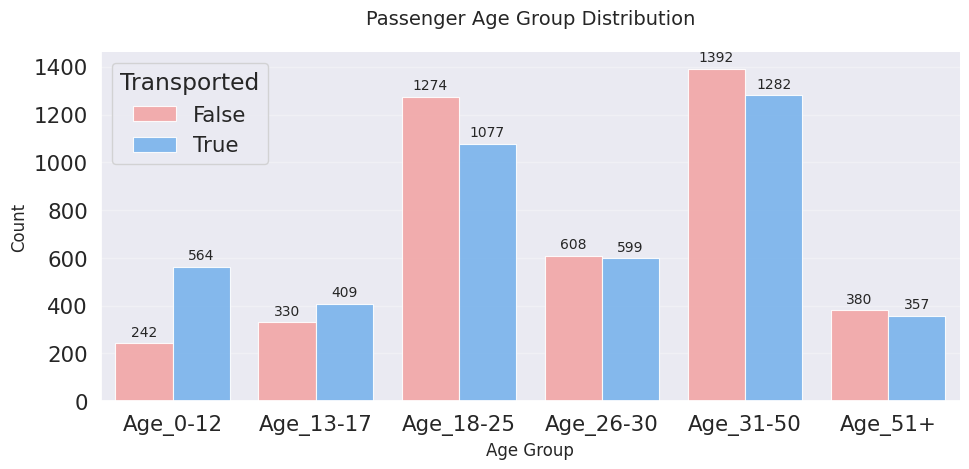

In [24]:
# Plot distribution of new features
palette = {True: '#66b3ff', False: '#ff9999'}

plt.figure(figsize=(10,5))

ax = sns.countplot(
    data=train,
    x='Age_group',
    hue='Transported',
    order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'],
    palette=palette,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.9
)

plt.title('Passenger Age Group Distribution', fontsize=14, pad=20)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3, fontsize=10)

plt.legend(title='Transported', labels=['False', 'True'])

plt.grid(axis='y', alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()

### **Expenditure**
Calculate total expenditure and identify passengers with no expenditure.

In [25]:
# New features - Training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - Testing set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

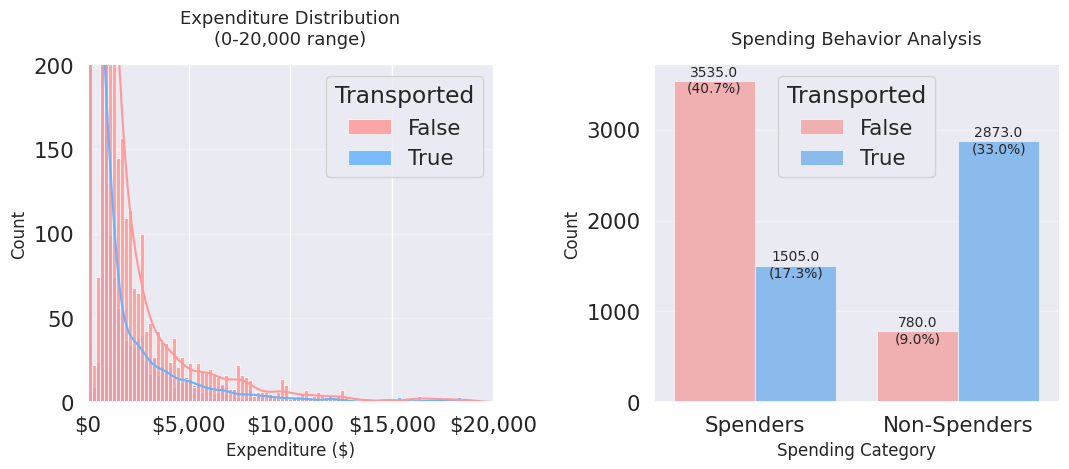

In [26]:
# Plot distribution of new features
palette = {True: '#66b3ff', False: '#ff9999'}

fig = plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
ax1 = sns.histplot(
    data=train[train['Expenditure'] <= 20000],
    x='Expenditure',
    hue='Transported',
    bins=100,
    palette=palette,
    edgecolor='white',
    linewidth=0.5,
    alpha=0.85,
    kde=True
)

plt.title('Expenditure Distribution\n(0-20,000 range)', fontsize=13, pad=15)
plt.xlabel('Expenditure ($)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.ylim([0, 200])
plt.xlim([0, 20000])

ax1.set_xticks(np.arange(0, 20001, 5000))
ax1.set_xticklabels([f'${x:,.0f}' for x in np.arange(0, 20001, 5000)])

plt.subplot(1, 2, 2)
ax2 = sns.countplot(
    data=train,
    x='No_spending',
    hue='Transported',
    palette=palette,
    edgecolor='white',
    linewidth=0.5,
    alpha=0.85,
    legend=True
)

plt.title('Spending Behavior Analysis', fontsize=13, pad=15)
plt.xlabel('Spending Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Spenders', 'Non-Spenders'])

for container in ax2.containers:
    for p in container.patches:
        height = p.get_height()
        percentage = height/len(train)*100
        ax2.text(p.get_x()+p.get_width()/2, height+10,
                f'{height}\n({percentage:.1f}%)',
                ha='center', va='center', fontsize=10)

for ax in [ax1, ax2]:
    ax.grid(axis='y', alpha=0.3)
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

### **Passenger Group**
Extract passenger group and group size from PassengerID

In [27]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

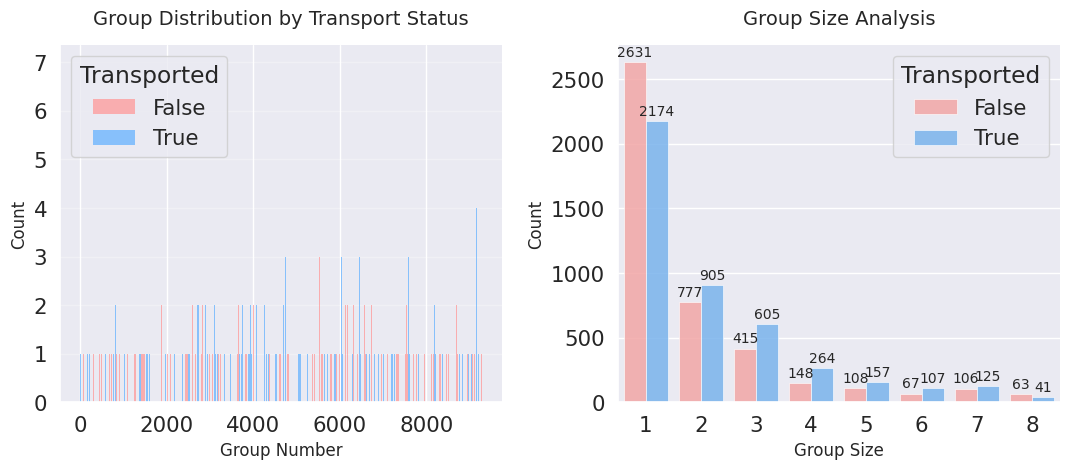

In [28]:
# Plot distribution of new features
palette = {True: '#66b3ff', False: '#ff9999'}

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
ax1 = sns.histplot(
    data=train,
    x='Group',
    hue='Transported',
    binwidth=1,
    palette=palette,
    hue_order=[True, False],
    edgecolor='white',
    multiple='dodge',
)

plt.title('Group Distribution by Transport Status', fontsize=14, pad=15)
plt.xlabel('Group Number', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
sns.despine(ax=ax1)
ax1.legend(title='Transported', labels=['False', 'True'])

plt.subplot(1, 2, 2)
ax2 = sns.countplot(
    data=train,
    x='Group_size',
    hue='Transported',
    palette=palette,
    edgecolor='white',
    linewidth=0.5,
    alpha=0.85,
    order=sorted(train['Group_size'].unique())
)

plt.title('Group Size Analysis', fontsize=14, pad=15)
plt.xlabel('Group Size', fontsize=12)
plt.ylabel('Count', fontsize=12)

for container in ax2.containers:
    ax2.bar_label(container,
                 fmt='%.0f',
                 padding=2,
                 fontsize=10)

sns.despine(ax=ax2)
ax2.legend(title='Transported', labels=['False', 'True'])

plt.tight_layout()
plt.show()

### **Solo**
The cardinality of the group feature is too large and would explode the number of dimensions. Group size is still a useful feature and can be further compressed by creating a Solo column because the figure shows that group size = 1 is less likely to be transported than group size > 1.

In [29]:
# New feature - Solo
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

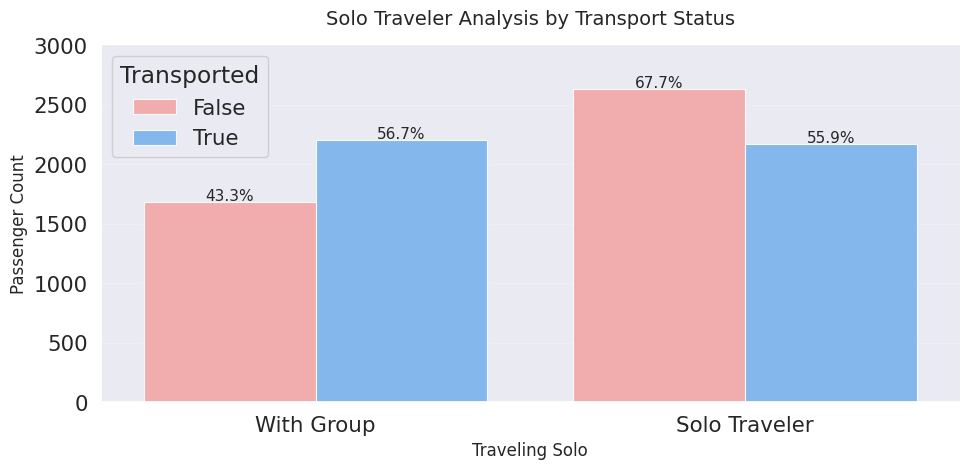

In [30]:
# New feature distribution
palette = {True: '#66b3ff', False: '#ff9999'}

plt.figure(figsize=(10,5))

ax = sns.countplot(
    data=train,
    x='Solo',
    hue='Transported',
    palette=palette,
    hue_order=[False, True],
    edgecolor='white',
    linewidth=0.8,
    alpha=0.9
)

plt.title('Solo Traveler Analysis by Transport Status', fontsize=14, pad=15)
plt.xlabel('Traveling Solo', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)
plt.ylim([0, 3000])
plt.xticks([0, 1], ['With Group', 'Solo Traveler'])

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        x_value = bar.get_x()
        group_total = len(train[train['Solo'] == (x_value == 1)])
        if group_total > 0:
            percentage = (height / group_total) * 100
            ax.text(bar.get_x() + bar.get_width()/2, height + 50,
                   f'{percentage:.1f}%',
                   ha='center', va='center',
                   fontsize=11)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['False', 'True'],
         title='Transported',
         frameon=True,
         framealpha=0.9)

plt.grid(axis='y', alpha=0.2)
sns.despine()

plt.tight_layout()
plt.show()

### **Cabin Location**
Extract deck, number, and side from cabin feature.

In [31]:
# Replace NaN's with outliers for now
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - Training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New Features - Test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop cabin
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

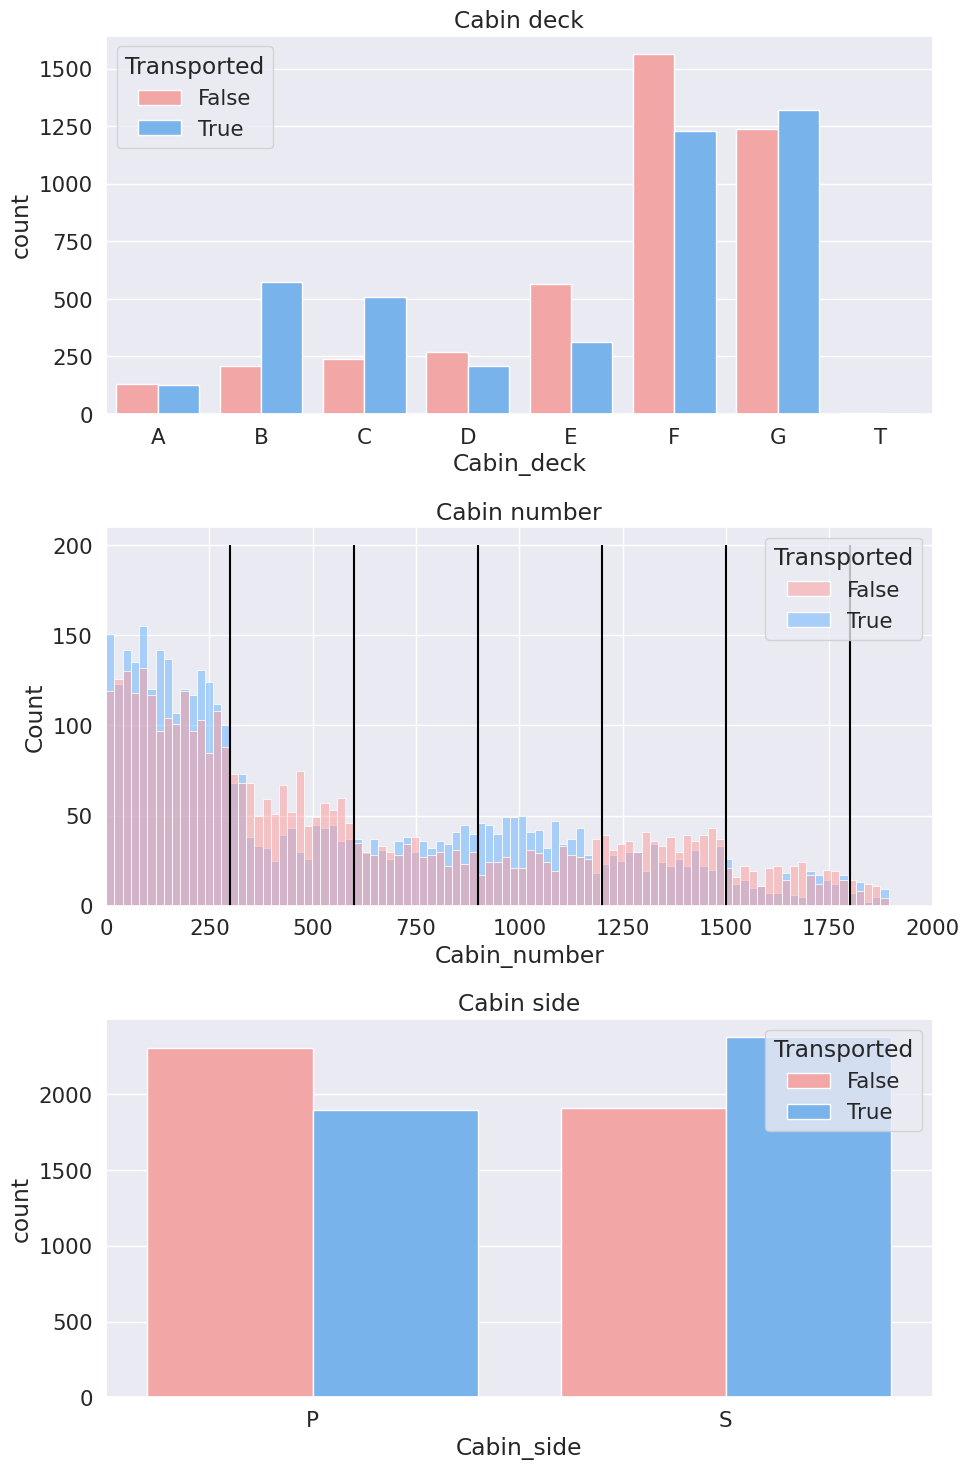

In [32]:
# Plot distribution of new Features
palette = {True: '#66b3ff', False: '#ff9999'}

fig = plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
sns.countplot(
    data=train,
    x='Cabin_deck',
    hue='Transported',
    order=['A','B','C','D','E','F','G','T'],
    palette=palette
)

plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(
    data=train,
    x='Cabin_number',
    hue='Transported',
    binwidth=20,
    palette=palette
)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(
    data=train,
    x='Cabin_side',
    hue='Transported',
    palette=palette
)

plt.title('Cabin side')

fig.tight_layout()
plt.show()

In [33]:
# New features - Training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - Test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

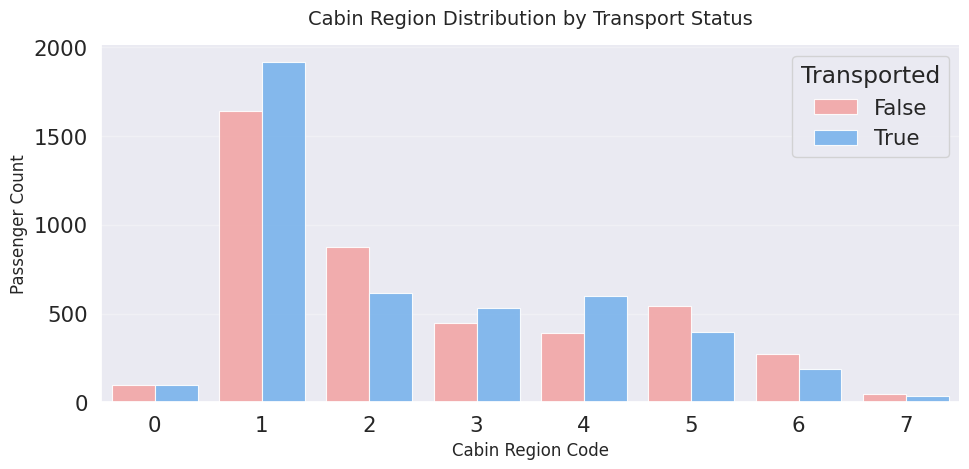

In [34]:
# Plot distribution of new features
palette = {True: '#66b3ff', False: '#ff9999'}

plt.figure(figsize=(10,5))
train['Cabin_regions_plot'] = (train['Cabin_region1'] +
                              2*train['Cabin_region2'] +
                              3*train['Cabin_region3'] +
                              4*train['Cabin_region4'] +
                              5*train['Cabin_region5'] +
                              6*train['Cabin_region6'] +
                              7*train['Cabin_region7']).astype(int)

ax = sns.countplot(
    data=train,
    x='Cabin_regions_plot',
    hue='Transported',
    palette=palette,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.9
)

plt.title('Cabin Region Distribution by Transport Status', fontsize=14, pad=15)
plt.xlabel('Cabin Region Code', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['False', 'True'],
           title='Transported',
           frameon=True)

plt.grid(axis='y', alpha=0.3)
sns.despine()

train.drop('Cabin_regions_plot', axis=1, inplace=True)

plt.tight_layout()
plt.show()

### **Last Name**
Calculate family size from last name.

In [35]:
# Replace NaN's with outliers for now
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

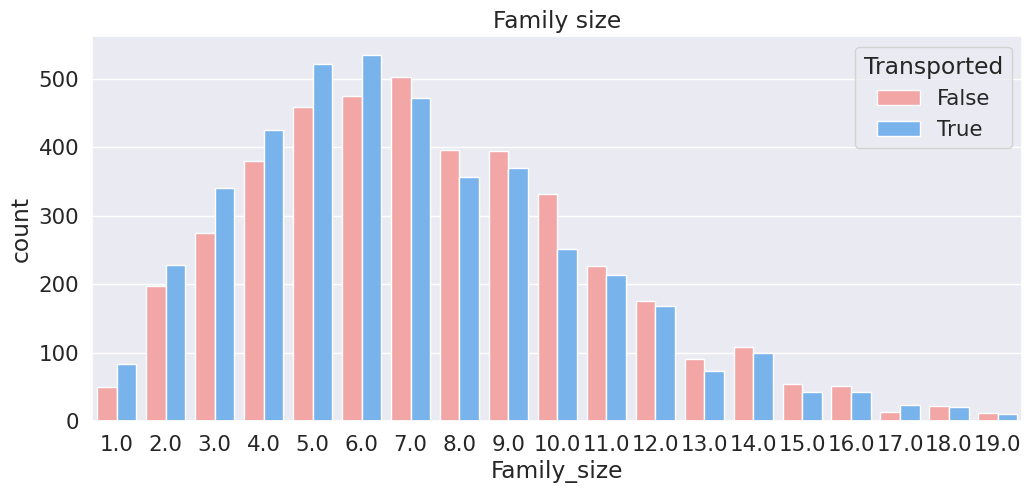

In [36]:
# New feature distribution
palette = {True: '#66b3ff', False: '#ff9999'}

plt.figure(figsize=(12,5))
sns.countplot(
    data=train,
    x='Family_size',
    hue='Transported',
    palette=palette
)
plt.title('Family size')
plt.show()

# ***Missing Values***

### **Combining Train and test**
We are combining the training and test set to make it easier to fill in missing values, we'll split it back later.

In [37]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)

### **Exploring Missing Values**

In [38]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv

,Number_missing,Percentage_missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


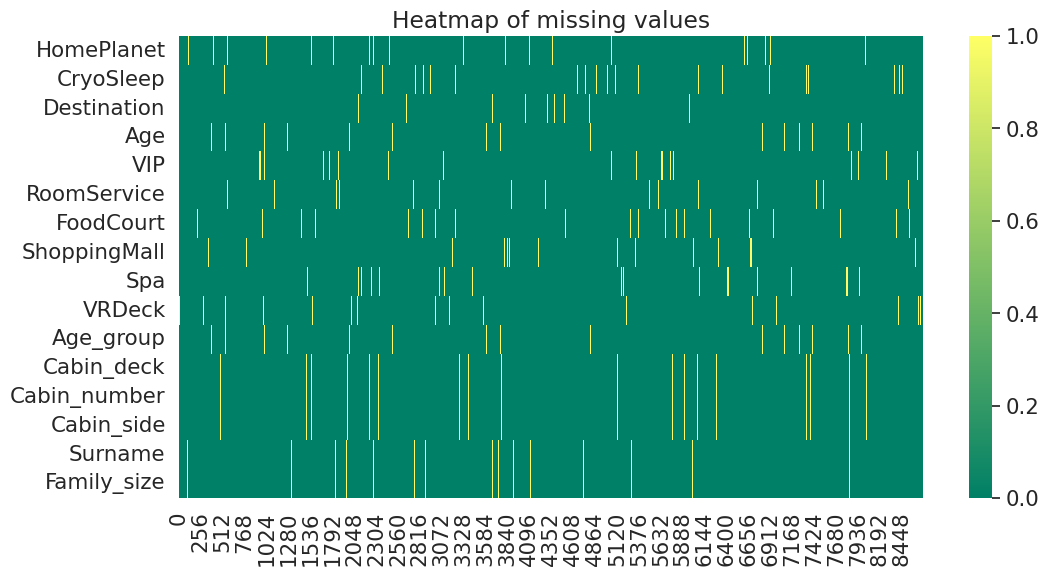

In [39]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')
plt.show()

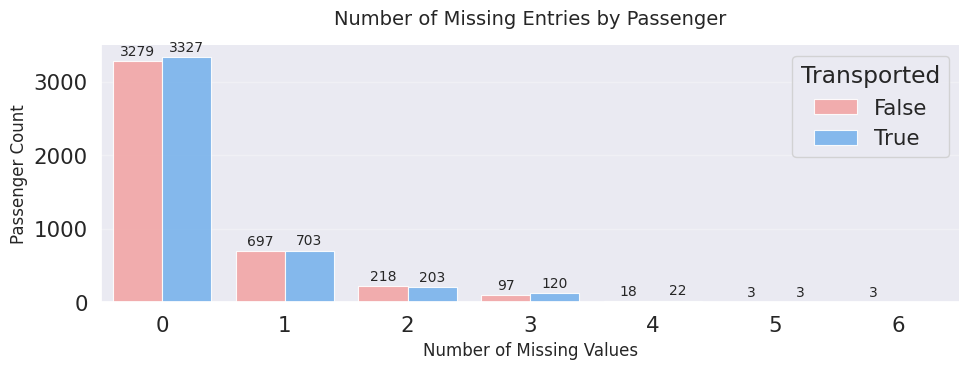

In [40]:
# Countplot of number of missing values by passenger

palette = {True: '#66b3ff', False: '#ff9999'}

plt.figure(figsize=(10,4))
train['na_count'] = train.isna().sum(axis=1)

ax = sns.countplot(
    data=train,
    x='na_count',
    hue='Transported',
    palette=palette,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.9
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=2, fontsize=10)

plt.title('Number of Missing Entries by Passenger', fontsize=14, pad=15)
plt.xlabel('Number of Missing Values', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['False', 'True'],
           title='Transported',
           frameon=True)

plt.grid(axis='y', alpha=0.3)
sns.despine()

train.drop('na_count', axis=1, inplace=True)

plt.tight_layout()
plt.show()

#### Insights:
* Missing values are independent of the target and for the most part isolated.
* even though only 2% of the data is missing, about 25% of all passengers have atleast 1 missing value.
* PassengerID is the only (original) feature to not have any missing values.

# ***Handling Missing Value***

A easy way of dealing with missing values is to use the median for continous features and mode for categorical features. However, since we want to maximize the accuracy of the model we need to look for patterns within the missing data. Here, we will look at the joint distribution of features.

### **HomePlanet and Group**

In [41]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


#### Insights:
This shows us that everyone in the same group comes from the same home planet. So we can fill the missing HomePlanet values according to group for all cases where group is greater than 1.

In [42]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


### **HomePlanet and CabinDeck**

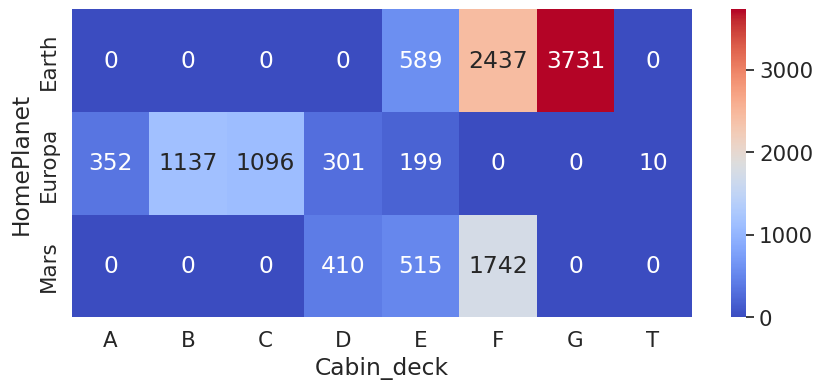

In [43]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

#### Insights:
* Passengers on decks A, B, C, or T came from Europa
* Passengers on deck G came from Earth
* Passengers on decks D, E, or F came from multiple planets.

In [44]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


### **HomePlanet and Surname**

In [45]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

#### Insights:
Everyone from the same surname should come from the same home planet.

In [46]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [47]:
# Only 10 HomePlanet missing values left
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


### **HomePlanet and Destination**

<Axes: xlabel='HomePlanet', ylabel='Destination'>

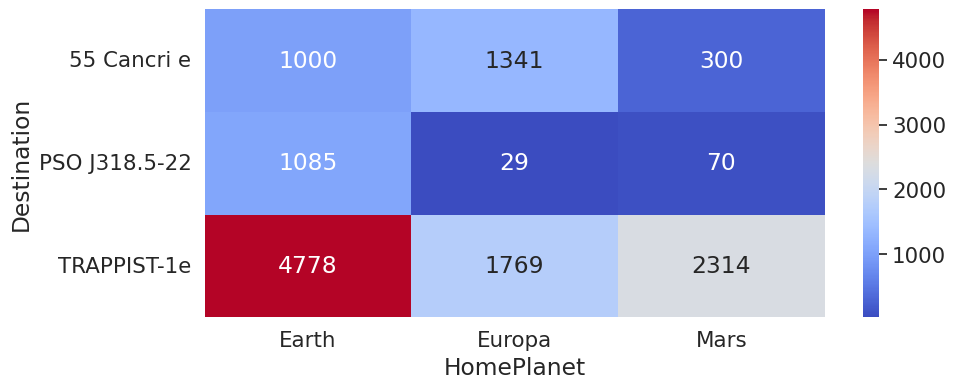

In [48]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

#### Insights:
Most people heading towards TRAPPIST-1e came from Earth but no one from Deck D came from Earth according to the data earlier so we need to filter that out.

In [49]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


### **Destination**

Since the majority of passengers are heading towards TRAPPIST-1e, we decided to just impute this value.

In [50]:
# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


### **Surname and Group**
Filling in missing surnames will improve the accuracy of the family size feature. We will do this by filling missing surnames according to the majority surname in that group.

In [51]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

In [52]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


In [53]:
# Replace NaN's with outliers
data['Surname'].fillna('Unknown', inplace=True)

# Update Family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's Back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown Surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

### **CabinSide and Group**
Everyone in the same group is also found in the same cabin side. For cabin deck and cabin number, there is also a fairly good but not perfect correlation with group.

In [54]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

In [55]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin Side
GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


### **CabinSide and Surname**

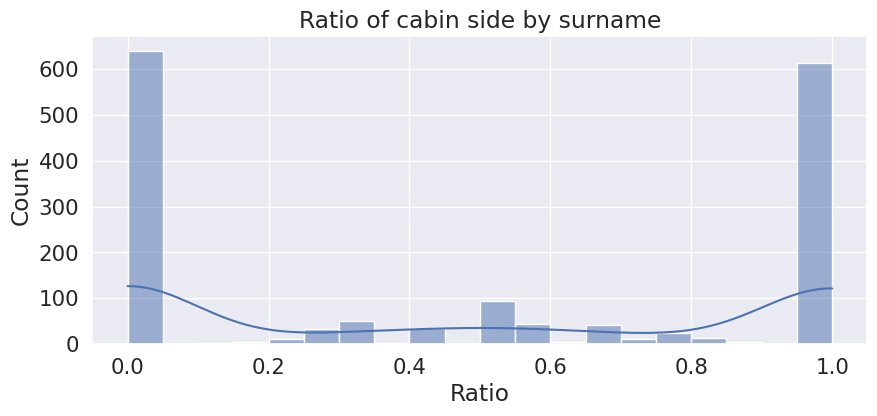

In [56]:
# Joint distribution of Surname and Cabin Side
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')
plt.show()

In [57]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 76.7 %


Cabin_side,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


In [58]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop Surname
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 66


In [59]:
# Value counts
data['Cabin_side'].value_counts()

,count
Cabin_side,
S,6504
P,6400


In [60]:
# Missing Values Before
CS_bef=data['Cabin_side'].isna().sum()

# Fill Remaining Missing Values With Outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print Number of Missing Values Left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


### **CabinDeck and Group**

In [61]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


### **CabinDeck and HomePlanet**

In [62]:
# Joint distribution
data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

#### Insights:
* Passengers from Mars are most likely to be in deck F
* Passengers from Europa are most likeyl to be in deck C if travelling solo and deck B otherwise.
* Passengers from Earth are most likely to be in deck G

In [63]:
# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Fill missing values using the mode
na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 0


### **CabinNumber and CabinDeck**

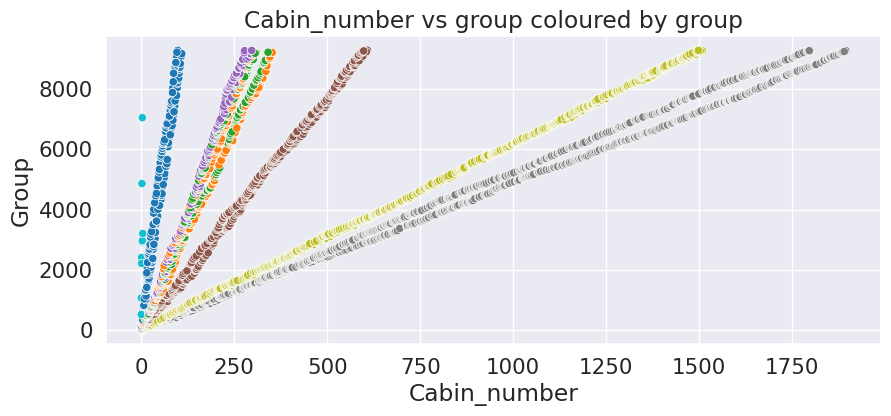

In [64]:
# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('Cabin_number vs group coloured by group')
plt.show()

#### Insights:
Cabin number and Group number share a linear relationship on a deck by deck basis. Therefore, we will extrapolate the missing cabin numbers using linear regression on a deck by deck basis to get an approximate Cabin numbers.

In [65]:
# Missing values before
CN_bef=data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))

    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


In [66]:
# One-hot encode cabin regions
data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

### **VIP**
VIP is a highly unbalanced feature so we will just impute the mode.

In [67]:
data['VIP'].value_counts()

,count
VIP,
False,12401
True,273


In [68]:
# Missing values before
V_bef=data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


### **Age**
Age varies across many features like home planet, group size, expenditure, and cabin deck. So we will impute missing values according to the median of these subgroups.

In [69]:
# Joint distribution
data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [70]:
# Missing values before
A_bef=data[exp_feats].isna().sum().sum()

# Fill missing values using the median
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


In [71]:
# Update age group feature
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

### **CryoSleep**
A person that undergoes CryoSleep cannot spend anything, so the best way to predict whether a person is in CryoSleep is to see if they spent anything.

In [72]:
# Joint distribution
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_spending,,
0,7339.0,0.0
1,740.0,4581.0


In [73]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


### **Expenditure and CryoSleep**

In [74]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,exp_feats].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [75]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


### **Expenditure and Others**
Expenditure varies across many features as well so we will only impute missing values using home planet, solo, and age to prevent overfitting.



In [76]:
# Joint distribution
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [77]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median
for col in exp_feats:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 866
#Expenditure missing values after: 0


In [78]:
# Update expenditure and no_spending
data['Expenditure']=data[exp_feats].sum(axis=1)
data['No_spending']=(data['Expenditure']==0).astype(int)

In [79]:
data.isna().sum()

,0
PassengerId,0
HomePlanet,0
CryoSleep,0
Destination,0
Age,0
VIP,0
RoomService,0
FoodCourt,0
ShoppingMall,0
Spa,0


# ***Preprocessing***

### **Splitting Data Back into Train and Test Sets**

In [80]:
# Train and test
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

### **Dropping Unwanted Features**

In [81]:
# Drop qualitative/redundant/collinear/high cardinality features
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

### **Log Transformation**
The logarithm transformation is used to decrease skew in distributions, especially with large outliers. It can make it easier for algorithms to learn the correct relationships.

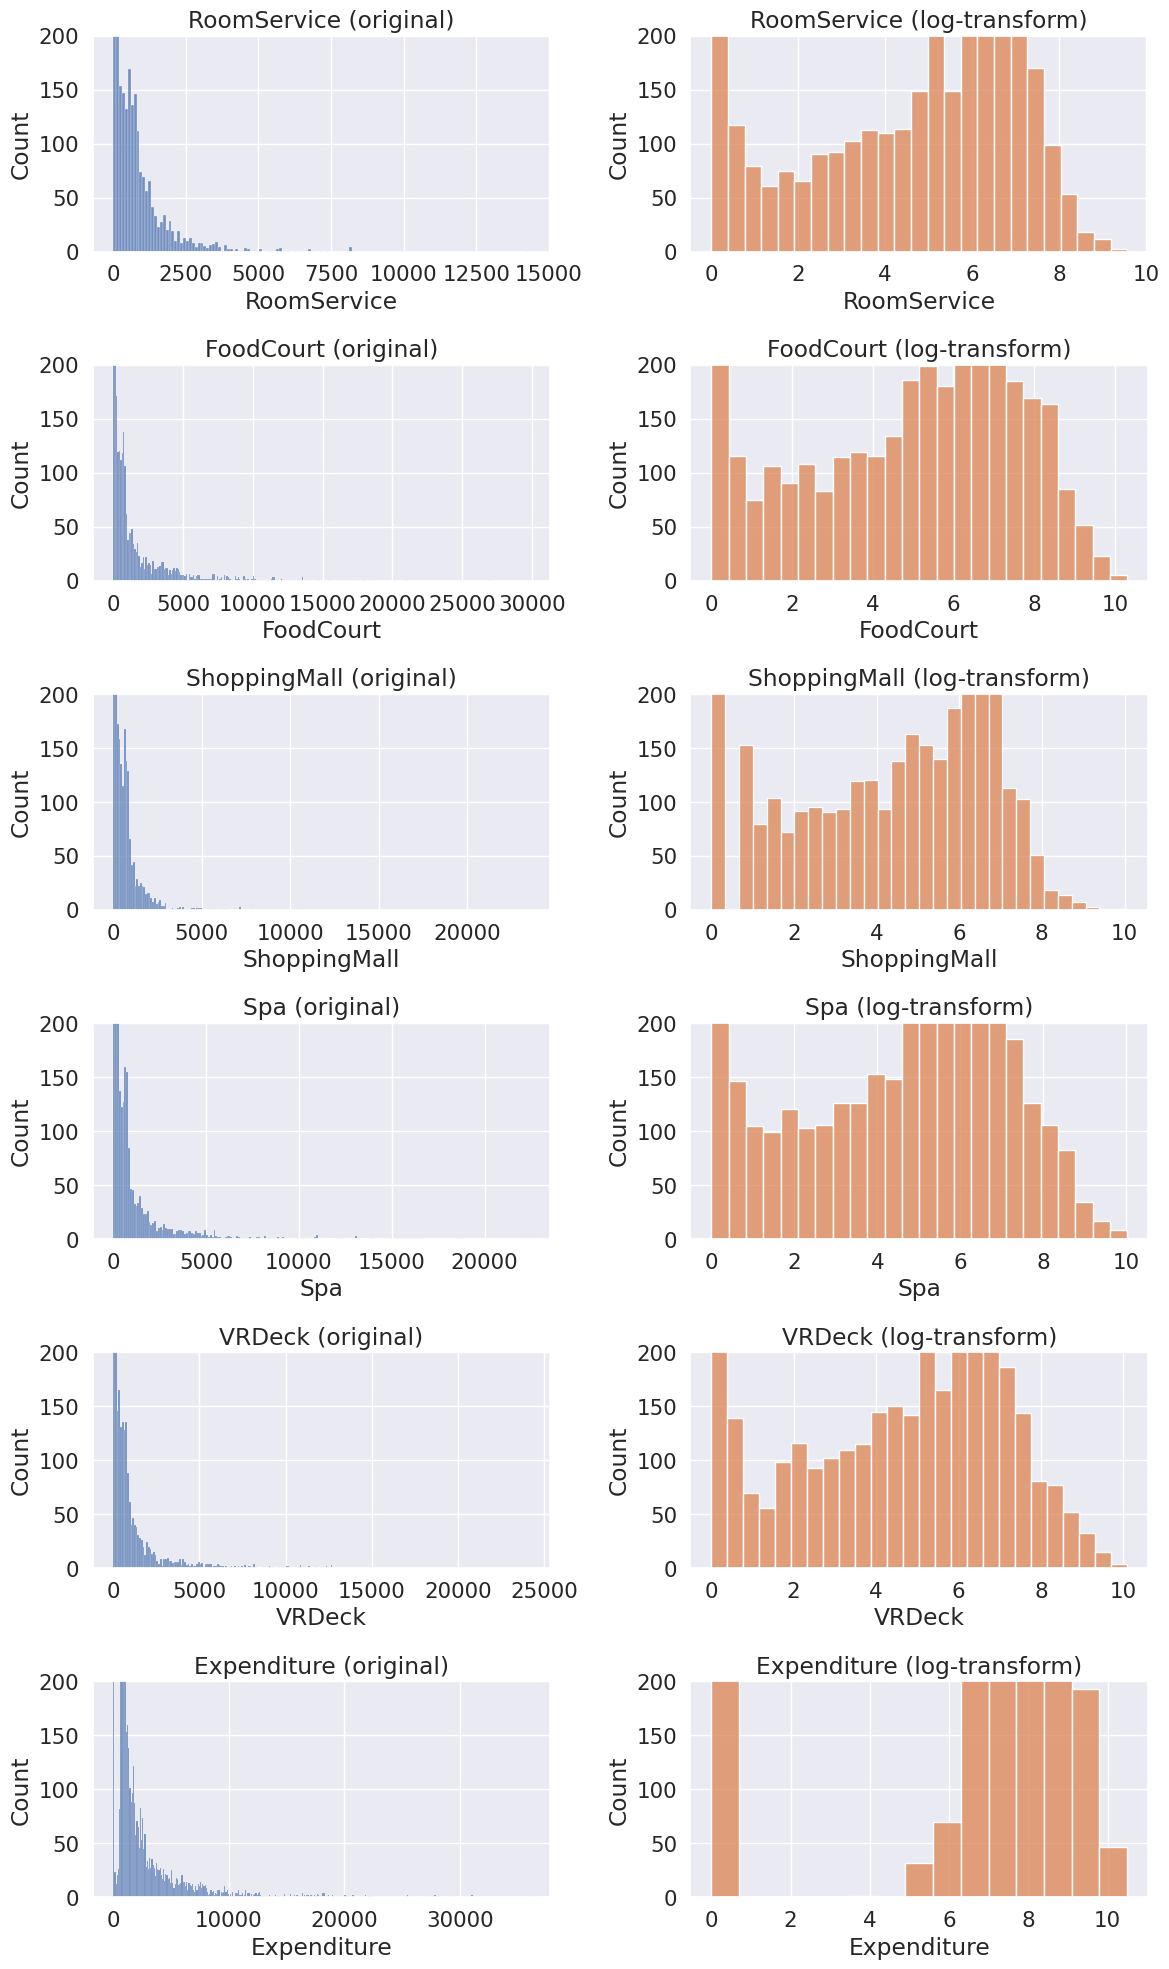

In [82]:
# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')

    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')

fig.tight_layout()
plt.show()

In [83]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

### **Encoding and Scaling**

In [84]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse_output=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 36)


### **Creating a Validation Set**

In [85]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

# ***Model Selection***
1. **Logistic Regression**: A simple, interpretable baseline for binary/multiclass problems, ideal for linearly separable data and quick benchmarking.
2. **K-Nearest Neighbors (KNN)**: A flexible, distance-based model that adapts to local patterns, useful for small-to-medium datasets with clear clusters.
3. **Support Vector Machine (SVM)**: Effective in high-dimensional spaces with kernel tricks, robust for non-linear classification when data isn’t linearly separable.
4. **Random Forest (RF)**: An ensemble method resistant to overfitting, handling mixed data types and non-linearity while providing feature importance.
5. **Light Gradient Boosting Machine (LGBM)**:  A fast, gradient-boosted model optimized for large datasets, excelling in predictive accuracy with minimal tuning.
6. **Categorical Boosting (CatBoost)**: Automatically handles categorical features and reduces overfitting, ideal for tabular data with heterogeneous variables.
7. **Naive Bayes (NB)**: A lightweight, probabilistic model efficient for high-dimensional data when features are roughly independent.



### **Defining Classifiers**

In [86]:
# Initialize storage for all metrics
all_metrics = {
    'roc': {},
    'confusion': {},
    'reports': {},
    'scores': pd.DataFrame(columns=['Classifier', 'Train Accuracy', 'Valid Accuracy',
                                  'Overfit Gap', 'CV Mean', 'CV Std', 'Time (mins)']),
    'best_params': {},
    'feature_importances': {}
}

# Classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=0, probability=True),
    "RandomForest": RandomForestClassifier(random_state=0),
    "LGBM": LGBMClassifier(random_state=0),
    "CatBoost": CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}


# Grids for grid search
LR_grid = {'penalty': ['l1', 'l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
           'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

NB_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

grid = {
    "LogisticRegression": LR_grid,
    "KNN": KNN_grid,
    "SVC": SVC_grid,
    "RandomForest": RF_grid,
    "LGBM": boosted_grid,
    "CatBoost": boosted_grid,
    "NaiveBayes": NB_grid
}

### **Training and Evaluating Models**

In [87]:
for key, classifier in classifiers.items():
    print(f"\n=== Training {key} ===")
    start = time.time()

    # Model training with GridSearchCV
    clf = GridSearchCV(classifier, grid[key], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)

    # Predictions
    y_train_pred = clf.predict(X_train)
    y_valid_pred = clf.predict(X_valid)
    y_valid_proba = clf.predict_proba(X_valid)[:,1]

    # Store ROC curve data correctly
    fpr, tpr, thresholds = roc_curve(y_valid, y_valid_proba)
    roc_auc = auc(fpr, tpr)
    all_metrics['roc'][key] = (fpr, tpr, thresholds, roc_auc)

    # Store other metrics
    all_metrics['confusion'][key] = confusion_matrix(y_valid, y_valid_pred)
    all_metrics['reports'][key] = classification_report(y_valid, y_valid_pred, output_dict=True)

    # Cross-validation
    cv_scores = cross_val_score(clf.best_estimator_, X_train, y_train, cv=5)

    # Store scores
    all_metrics['scores'].loc[len(all_metrics['scores'])] = [
        key,
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_valid, y_valid_pred),
        accuracy_score(y_train, y_train_pred) - accuracy_score(y_valid, y_valid_pred),
        cv_scores.mean(),
        cv_scores.std(),
        np.round((time.time() - start)/60, 2)
    ]


=== Training LogisticRegression ===

=== Training KNN ===

=== Training SVC ===

=== Training RandomForest ===

=== Training LGBM ===
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1696
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

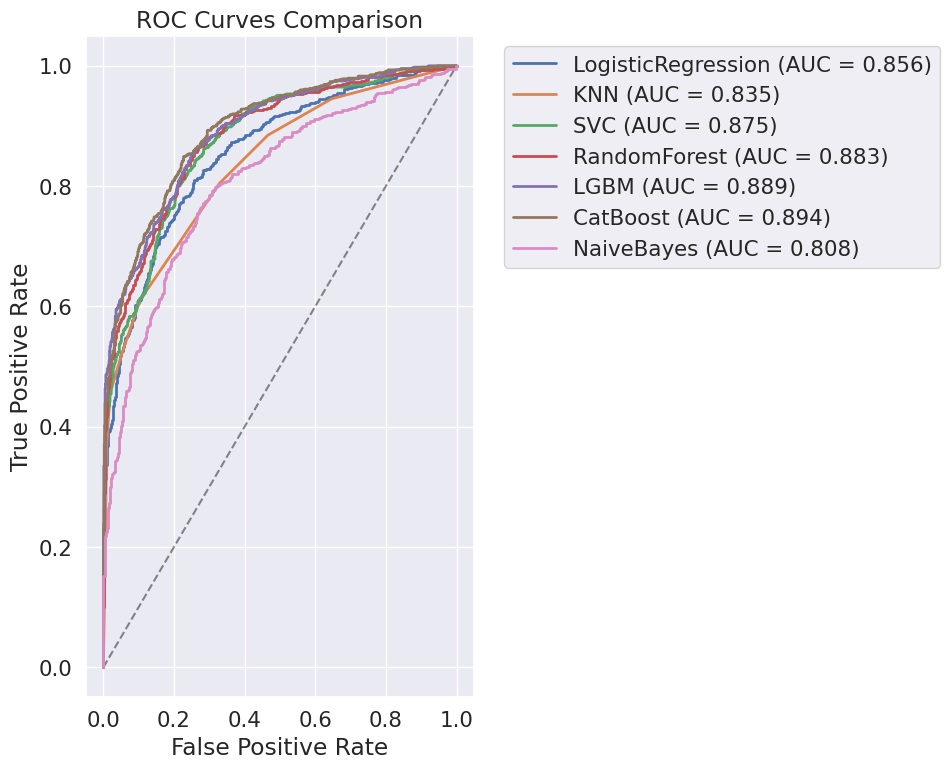

In [88]:
# 1. ROC Curves Comparison
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
for model, (fpr, tpr, _, auc_score) in all_metrics['roc'].items():
    plt.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {auc_score:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

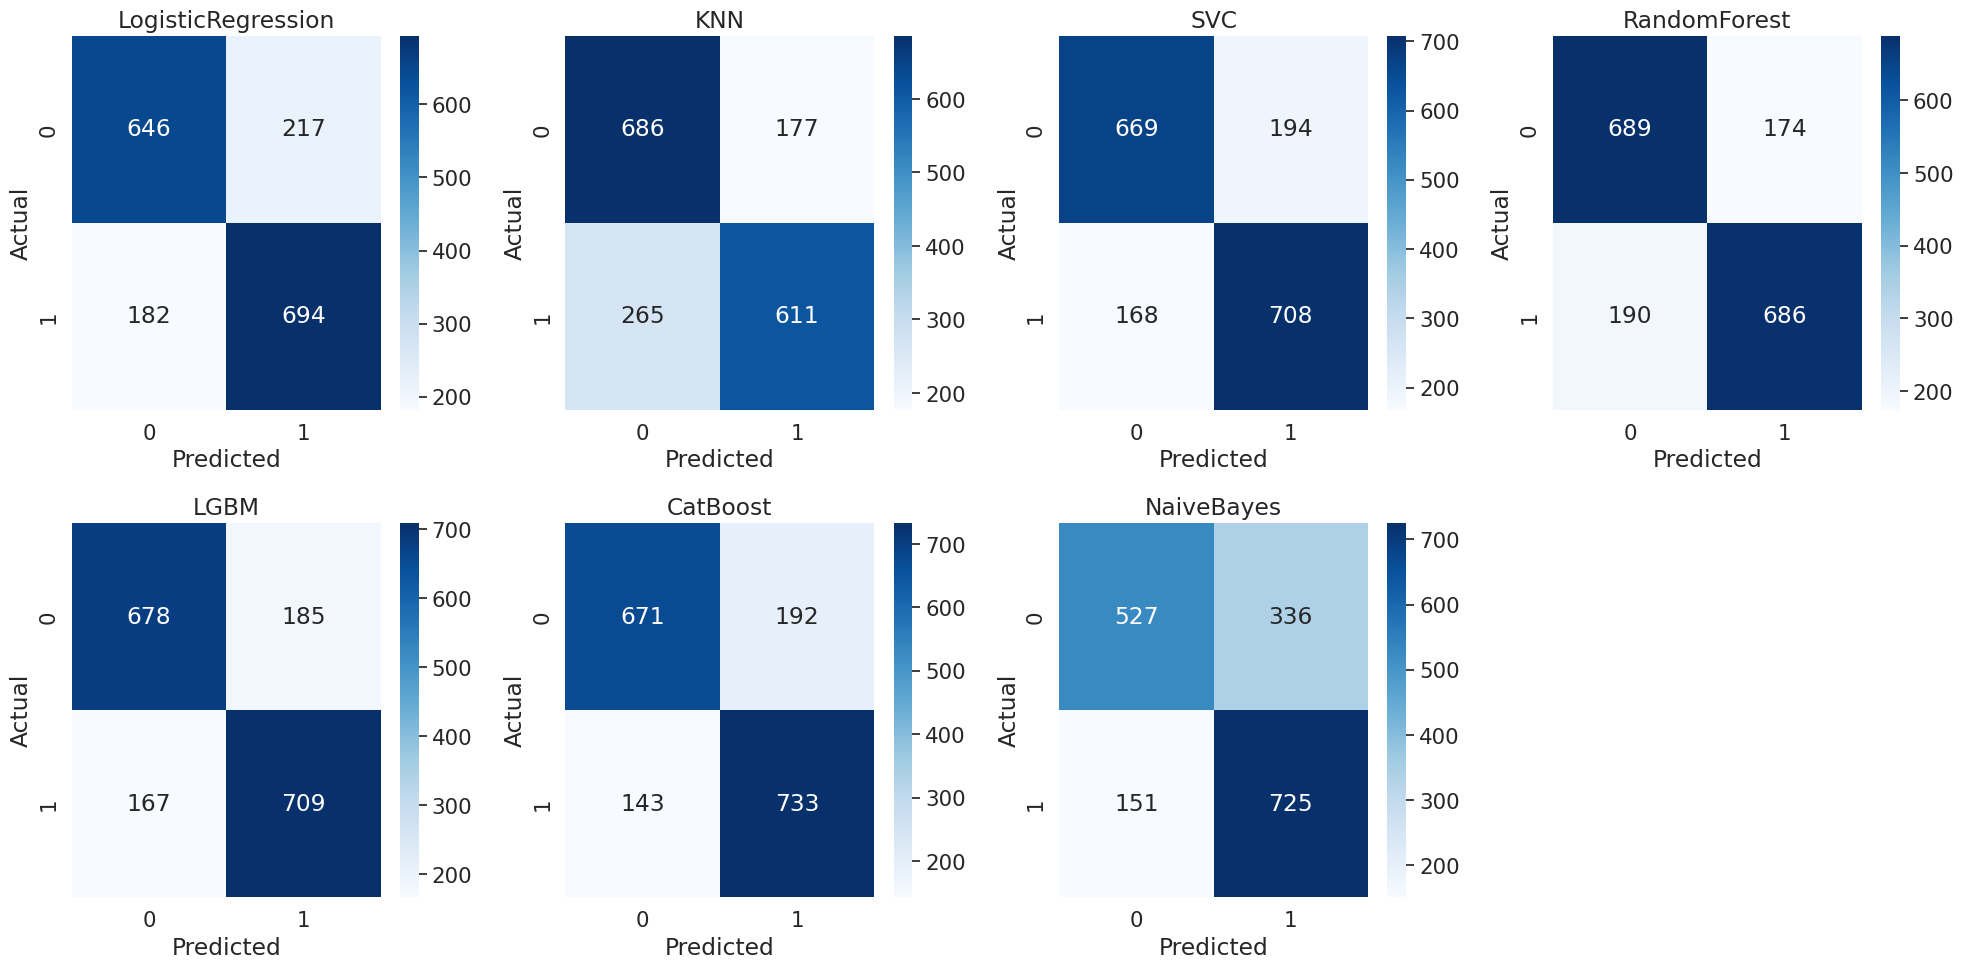

In [89]:
# 2. Confusion Matrices Grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for (model, cm), ax in zip(all_metrics['confusion'].items(), axes.flatten()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
fig.delaxes(axes[1,3])  # Remove empty subplot
plt.tight_layout()
plt.show()

In [90]:
# 3. Classification Reports
print("\n=== Detailed Classification Reports ===")
for model, report in all_metrics['reports'].items():
    print(f"\n{model.upper()} CLASSIFICATION REPORT:")
    print(pd.DataFrame(report).transpose().round(3))


=== Detailed Classification Reports ===

LOGISTICREGRESSION CLASSIFICATION REPORT:
              precision  recall  f1-score   support
0                 0.780   0.749     0.764   863.000
1                 0.762   0.792     0.777   876.000
accuracy          0.771   0.771     0.771     0.771
macro avg         0.771   0.770     0.770  1739.000
weighted avg      0.771   0.771     0.770  1739.000

KNN CLASSIFICATION REPORT:
              precision  recall  f1-score   support
0                 0.721   0.795     0.756   863.000
1                 0.775   0.697     0.734   876.000
accuracy          0.746   0.746     0.746     0.746
macro avg         0.748   0.746     0.745  1739.000
weighted avg      0.749   0.746     0.745  1739.000

SVC CLASSIFICATION REPORT:
              precision  recall  f1-score   support
0                 0.799   0.775     0.787   863.000
1                 0.785   0.808     0.796   876.000
accuracy          0.792   0.792     0.792     0.792
macro avg         0.792   0.

In [91]:
# 4. Performance Metrics Table
print("\n=== Model Performance Summary ===")
display(all_metrics['scores'].sort_values('Valid Accuracy', ascending=False))


=== Model Performance Summary ===


,Classifier,Train Accuracy,Valid Accuracy,Overfit Gap,CV Mean,CV Std,Time (mins)
5,CatBoost,0.836785,0.807361,0.029424,0.815071,0.007517,18.72
4,LGBM,0.854328,0.797585,0.056744,0.812914,0.009180,0.70
2,SVC,0.825999,0.791834,0.034165,0.802561,0.005583,16.77
3,RandomForest,0.877912,0.790684,0.087228,0.808455,0.007572,2.43
0,LogisticRegression,0.780414,0.770558,0.009856,0.779697,0.006725,0.12
1,KNN,0.827006,0.745831,0.081175,0.776100,0.008045,0.13
6,NaiveBayes,0.737705,0.719954,0.017751,0.737849,0.012690,0.01


# ***Modelling***

### **Defining the Best Model**

In [92]:
best_model_name = all_metrics['scores'].loc[all_metrics['scores']['Valid Accuracy'].idxmax(), 'Classifier']
print(f"\nBest performing model: {best_model_name}")


Best performing model: CatBoost


### **Applying the Best Model**

In [112]:
if best_model_name == "CatBoost":
    best_model = CatBoostClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.15,
    )

In [106]:
X_full = np.vstack([X_train, X_valid])
y_full = np.concatenate([y_train, y_valid])

In [107]:
best_model.fit(X_full, y_full)


0:	learn: 0.6343647	total: 14.8ms	remaining: 1.47s
1:	learn: 0.5930817	total: 21.5ms	remaining: 1.05s
2:	learn: 0.5678086	total: 30ms	remaining: 970ms
3:	learn: 0.5462869	total: 41ms	remaining: 985ms
4:	learn: 0.5263787	total: 57.2ms	remaining: 1.09s
5:	learn: 0.5159035	total: 67.1ms	remaining: 1.05s
6:	learn: 0.4989358	total: 78.3ms	remaining: 1.04s
7:	learn: 0.4903935	total: 91.1ms	remaining: 1.05s
8:	learn: 0.4810867	total: 101ms	remaining: 1.02s
9:	learn: 0.4732961	total: 110ms	remaining: 990ms
10:	learn: 0.4697114	total: 119ms	remaining: 965ms
11:	learn: 0.4621624	total: 129ms	remaining: 945ms
12:	learn: 0.4590855	total: 138ms	remaining: 924ms
13:	learn: 0.4523564	total: 148ms	remaining: 908ms
14:	learn: 0.4496910	total: 157ms	remaining: 888ms
15:	learn: 0.4465786	total: 165ms	remaining: 869ms
16:	learn: 0.4422239	total: 174ms	remaining: 852ms
17:	learn: 0.4392399	total: 183ms	remaining: 835ms
18:	learn: 0.4358050	total: 195ms	remaining: 830ms
19:	learn: 0.4319802	total: 205ms	rem

In [108]:
test_predictions = best_model.predict(X_test)

In [109]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': test_predictions
})

In [110]:
submission.to_csv('submission.csv', index=False)
print("Test predictions saved to submission.csv")

Test predictions saved to submission.csv


In [111]:
print("\nPrediction distribution:")
print(submission['Transported'].value_counts())


Prediction distribution:
Transported
1    2285
0    1992
Name: count, dtype: int64


# ***References***

Howard, Addison, et al. Spaceship Titanic. 2022, https://kaggle.com/competitions/spaceship-titanic.